In [56]:
import pennylane as qml
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [57]:
# n qubits case
n = 4
dev = qml.device('default.qubit', wires=n+1)

In [58]:
# two qubit case
def real(angles, **kwargs):
    for i in range(n):
        qml.Rot(*angles, wires=i)
    
    qml.Hadamard(wires=n)

    for i in range(n):
        qml.CZ(wires=[i, i+1])

In [59]:
def utheta(w, wires, **kwargs):
    pos = 0
    for i in range(len(wires)):
        qml.RX(w[pos], wires=wires[i])
        qml.RY(w[pos+1], wires=wires[i])
        qml.RZ(w[pos+2], wires=wires[i])
        pos += 3

    for layer in range(n):
        for i in range(len(wires)-1):
            qml.CNOT(wires=[wires[i], wires[i+1]])
        
        for i in range(len(wires)):
            qml.RX(w[pos], wires=wires[i])
            qml.RY(w[pos+1], wires=wires[i])
            qml.RZ(w[pos+2], wires=wires[i])
            pos += 3


In [60]:
@qml.qnode(dev, interface="tf")
def qpca(angles, theta_weights, **kwargs):
    real(angles)
    utheta(theta_weights, list(range(n)))
    z = []
    for i in range(n):
        z.append(qml.expval(qml.PauliZ(i)))
    return z

In [61]:
def pcaloss(angles, theta_weights, **kwargs):
    z = qpca(angles, theta_weights)
    return 1 / 2 ** n / (2 ** n - 1) * tf.math.reduce_sum((z + 1) * (2 ** tf.range(n, dtype=tf.double)))

In [36]:
angles = [np.pi / 6, np.pi / 2, np.pi / 7]

np.random.seed(0)
eps = 1e-2
n_param = (n + 1) * 3 * n
init_theta_weights = np.array([0] * n_param) + \
                   np.random.normal(scale=eps, size=(n_param,))
theta_weights = tf.Variable(init_theta_weights)

opt = tf.keras.optimizers.Adam(0.1)

In [37]:
@qml.qnode(dev, interface="tf")
def show_real(angles, **kwargs):
    real(angles)
    return qml.density_matrix(list(range(n)))
real_matrix = show_real(angles).numpy()
U, S, V = np.linalg.svd(real_matrix)
print(S)
minloss = np.sum(S * np.arange(len(S))) / 2 ** n / (2 ** n - 1) * 2
print(minloss)

[5.00000000e-01 5.00000000e-01 5.74888259e-17 3.84048010e-17
 2.86995323e-17 2.16142100e-17 1.45120227e-17 1.18067555e-17
 1.00232470e-17 5.90193846e-18 3.86791383e-18 1.29089134e-18
 2.09579435e-33 1.16538214e-33 5.00243041e-34 2.26390137e-34]
0.0041666666666666735


Step 0: cost = 0.06371581445805832
Step 5: cost = 0.037889679404620846
Step 10: cost = 0.02017298878809917
Step 15: cost = 0.01557961031373817
Step 20: cost = 0.010949306051024182
Step 25: cost = 0.006640577819045232
Step 30: cost = 0.004967921819693237
Step 35: cost = 0.005107150653662218
Step 40: cost = 0.00477117672719966
Step 45: cost = 0.00441730974690667
Step 50: cost = 0.004331926888970736
Step 55: cost = 0.004245736833460846
Step 60: cost = 0.0042619852038890075
Step 65: cost = 0.004209958907391226
Step 70: cost = 0.0041927010041647094
Step 75: cost = 0.004180419985148465
Step 80: cost = 0.004175229255030104
Step 85: cost = 0.004172117570554472
Step 90: cost = 0.004170630481302309
Step 95: cost = 0.004169265878118608
Step 100: cost = 0.004168216600566929
Step 105: cost = 0.004167728278494397
Step 110: cost = 0.004167354954932928
Step 115: cost = 0.004167144563904104
Step 120: cost = 0.004166953012653949
Step 125: cost = 0.0041668734826220966
Step 130: cost = 0.00416683470413728

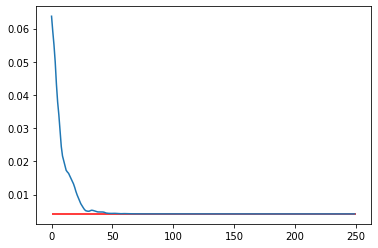

In [38]:
cost = lambda: pcaloss(angles, theta_weights)
n_step = 250
cost_list = []
for step in range(n_step):
    opt.minimize(cost, theta_weights)
    cost_val = cost().numpy()
    cost_list.append(cost_val)
    if step % 5 == 0:
        print("Step {}: cost = {}".format(step, cost_val))
plt.plot(np.arange(n_step), cost_list)
plt.hlines(minloss, 0, n_step, color='r')
plt.show()

In [39]:
@qml.qnode(dev, interface="tf")
def show_real_diag(angles, theta_weights, **kwargs):
    real(angles)
    utheta(theta_weights, list(range(n)))
    return qml.density_matrix(list(range(n)))

[5.00000000e-01 5.00000000e-01 5.74888259e-17 3.84048010e-17
 2.86995323e-17 2.16142100e-17 1.45120227e-17 1.18067555e-17
 1.00232470e-17 5.90193846e-18 3.86791383e-18 1.29089134e-18
 2.09579435e-33 1.16538214e-33 5.00243041e-34 2.26390137e-34]
[4.99999994e-01 4.99999993e-01 5.08575614e-09 3.58609044e-09
 1.31660108e-09 9.10098914e-10 6.32527857e-10 5.66850621e-10
 2.40868359e-10 1.95443669e-10 1.60988261e-10 1.15647998e-10
 1.00019055e-10 7.75175418e-11 2.39091884e-11 4.66459773e-12]


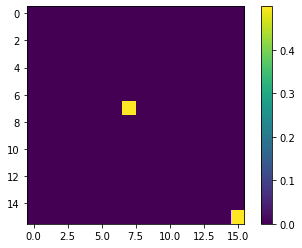

In [40]:
print(S)
print(-np.sort(-np.abs(np.diag(show_real_diag(angles, theta_weights).numpy()))))
plt.imshow(np.abs(show_real_diag(angles, theta_weights).numpy()))
plt.colorbar()
plt.show()